In [1]:
import numpy as np
import pandas as pd
from data_reader import read_consumption_and_weather
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

from utils import *

from models.base_model import BaseModel

torch.manual_seed(1)

In [2]:
_, _, df = read_consumption_and_weather()

df1 = df['NO1']
df2 = df['NO2']
df3 = df['NO3']
df4 = df['NO4']
df5 = df['NO5']

Holes by length and occurrences in column NO3:
Filling holes up to length 3
Any remaining holes after interpolation? False


In [3]:
df1

,consumption,temperature
2017-05-01 00:00:00+00:00,3325.431995,2.200000
2017-05-01 01:00:00+00:00,3344.690998,3.200000
2017-05-01 02:00:00+00:00,3398.359002,4.000000
2017-05-01 03:00:00+00:00,3430.220001,3.600000
2017-05-01 04:00:00+00:00,3606.750000,3.400000
...,...,...
2023-01-21 19:00:00+00:00,5947.502808,-10.233333
2023-01-21 20:00:00+00:00,5868.196111,-11.266667
2023-01-21 21:00:00+00:00,5742.156776,-12.016667
2023-01-21 22:00:00+00:00,5653.673398,-12.083333


In [4]:
consumption = df1['consumption'].shift(periods=1, fill_value=0)
consumption

2017-05-01 00:00:00+00:00       0.000000
2017-05-01 01:00:00+00:00    3325.431995
2017-05-01 02:00:00+00:00    3344.690998
2017-05-01 03:00:00+00:00    3398.359002
2017-05-01 04:00:00+00:00    3430.220001
                                ...     
2023-01-21 19:00:00+00:00    5996.773735
2023-01-21 20:00:00+00:00    5947.502808
2023-01-21 21:00:00+00:00    5868.196111
2023-01-21 22:00:00+00:00    5742.156776
2023-01-21 23:00:00+00:00    5653.673398
Freq: H, Name: consumption, Length: 50208, dtype: float64

In [5]:
target = df1['consumption']
target

2017-05-01 00:00:00+00:00    3325.431995
2017-05-01 01:00:00+00:00    3344.690998
2017-05-01 02:00:00+00:00    3398.359002
2017-05-01 03:00:00+00:00    3430.220001
2017-05-01 04:00:00+00:00    3606.750000
                                ...     
2023-01-21 19:00:00+00:00    5947.502808
2023-01-21 20:00:00+00:00    5868.196111
2023-01-21 21:00:00+00:00    5742.156776
2023-01-21 22:00:00+00:00    5653.673398
2023-01-21 23:00:00+00:00    5523.002220
Freq: H, Name: consumption, Length: 50208, dtype: float64

In [6]:
temp = df1['temperature'].shift(periods=1, fill_value=0)
temp

2017-05-01 00:00:00+00:00     0.000000
2017-05-01 01:00:00+00:00     2.200000
2017-05-01 02:00:00+00:00     3.200000
2017-05-01 03:00:00+00:00     4.000000
2017-05-01 04:00:00+00:00     3.600000
                               ...    
2023-01-21 19:00:00+00:00    -9.800000
2023-01-21 20:00:00+00:00   -10.233333
2023-01-21 21:00:00+00:00   -11.266667
2023-01-21 22:00:00+00:00   -12.016667
2023-01-21 23:00:00+00:00   -12.083333
Freq: H, Name: temperature, Length: 50208, dtype: float64

In [7]:
temp_forecast = df1['temperature']
temp_forecast

2017-05-01 00:00:00+00:00     2.200000
2017-05-01 01:00:00+00:00     3.200000
2017-05-01 02:00:00+00:00     4.000000
2017-05-01 03:00:00+00:00     3.600000
2017-05-01 04:00:00+00:00     3.400000
                               ...    
2023-01-21 19:00:00+00:00   -10.233333
2023-01-21 20:00:00+00:00   -11.266667
2023-01-21 21:00:00+00:00   -12.016667
2023-01-21 22:00:00+00:00   -12.083333
2023-01-21 23:00:00+00:00   -12.266667
Freq: H, Name: temperature, Length: 50208, dtype: float64

In [8]:
hour = pd.Series(df1.index.hour, name="hour_next_t")
day = pd.Series(df1.index.day, name="day_next_t")
month = pd.Series(df1.index.month, name="month_next_t")
year = pd.Series(df1.index.year, name="year_next_t")

len(hour), len(day), len(month), len(year)

(50208, 50208, 50208, 50208)

In [9]:
# Concatenate temperature and forecast so that each row contains temp, next day forecast
df_ = pd.concat([temp_forecast, consumption, target], axis=1)
df_ = df_.assign(hour_next_t=hour.values)
df_ = df_.assign(day_next_t=day.values)
df_ = df_.assign(month_next_t=month.values)
df_ = df_.assign(year_next_t=year.values)
df_.columns = ['forecast', 'consumption', 'next_timestep_consumption', 'hour_next_t', 'day_next_t', 'month_next_t', 'year_next_t']
df_ = df_.tail(-1)
df_

,forecast,consumption,next_timestep_consumption,hour_next_t,day_next_t,month_next_t,year_next_t
2017-05-01 01:00:00+00:00,3.200000,3325.431995,3344.690998,1,1,5,2017
2017-05-01 02:00:00+00:00,4.000000,3344.690998,3398.359002,2,1,5,2017
2017-05-01 03:00:00+00:00,3.600000,3398.359002,3430.220001,3,1,5,2017
2017-05-01 04:00:00+00:00,3.400000,3430.220001,3606.750000,4,1,5,2017
2017-05-01 05:00:00+00:00,3.100000,3606.750000,3739.876998,5,1,5,2017
...,...,...,...,...,...,...,...
2023-01-21 19:00:00+00:00,-10.233333,5996.773735,5947.502808,19,21,1,2023
2023-01-21 20:00:00+00:00,-11.266667,5947.502808,5868.196111,20,21,1,2023
2023-01-21 21:00:00+00:00,-12.016667,5868.196111,5742.156776,21,21,1,2023
2023-01-21 22:00:00+00:00,-12.083333,5742.156776,5653.673398,22,21,1,2023


In [10]:
# Get the 0.8 first timesteps for training and 0.2 last one for testing
df_train, df_test = train_test_split(df_, test_size=0.2, shuffle=False)
# Divide into train, validation
df_train, df_validation = train_test_split(df_train, test_size=0.1)

In [11]:
# Save for undoing normalization in testing
train_mean = df_train.mean()
train_std = df_train.std()

# Normalize train and test set
df_train = (df_train - train_mean) / train_std
df_validation = (df_validation - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10042 entries, 2021-11-29 14:00:00+00:00 to 2023-01-21 23:00:00+00:00
Freq: H
Data columns (total 7 columns):
forecast                     10042 non-null float64
consumption                  10042 non-null float64
next_timestep_consumption    10042 non-null float64
hour_next_t                  10042 non-null float64
day_next_t                   10042 non-null float64
month_next_t                 10042 non-null float64
year_next_t                  10042 non-null float64
dtypes: float64(7)
memory usage: 627.6 KB


Resulting DataFrame on form: "Date/Time t+1", "Temperature t", "Temperature t+1 (forecast)", "Consumption t", "Consumption t+1 (target)"

In [13]:
# Make Pytorch compatible dataloader
target_train = torch.tensor(df_train['next_timestep_consumption'].values.astype(np.float32))
features_train = torch.tensor(df_train.drop('next_timestep_consumption', axis=1).values.astype(np.float32))

target_val = torch.tensor(df_validation['next_timestep_consumption'].values.astype(np.float32))
features_val = torch.tensor(df_validation.drop('next_timestep_consumption', axis=1).values.astype(np.float32))

target_test = torch.tensor(df_test['next_timestep_consumption'].values.astype(np.float32))
features_test = torch.tensor(df_test.drop('next_timestep_consumption', axis=1).values.astype(np.float32))


In [14]:
train_tensor = torch.utils.data.TensorDataset(features_train, target_train)
train_loader = torch.utils.data.DataLoader(dataset=train_tensor, batch_size=64, shuffle=True)

val_tensor = torch.utils.data.TensorDataset(features_val, target_val)
val_loader = torch.utils.data.DataLoader(dataset=val_tensor, batch_size=64, shuffle=False)

test_tensor = torch.utils.data.TensorDataset(features_test, target_test)
test_loader = torch.utils.data.DataLoader(dataset=test_tensor, batch_size=25, shuffle=False)

In [15]:
loss_fn = torch.nn.MSELoss()

model = BaseModel()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

losses = []
losses_show = []
val_losses = []

# Training
for epoch in range(50):
    epoch_loss = []
    for i, data in enumerate(train_loader):
        features, targets = data

        # Make predictions for this batch
        outputs = model(features)

        # Compute loss and gradients
        loss = loss_fn(outputs, targets.view(-1, 1))
        
        # Zero gradients
        optimizer.zero_grad()

        loss.backward()

        # Update weights 
        optimizer.step()

        losses.append(loss.item())
        epoch_loss.append(loss.item())
        if len(losses) > 20:
            losses_show.append(sum(losses[-20:]) / 20)
        else:
            losses_show.append(losses[-1])

    # Validation Step
    val_loss = []
    for i, data in enumerate(val_loader):
        f, t = data
        output = model(f)
        loss = loss_fn(output, t.view(-1, 1))
        val_loss.append(loss.item())
    
    avg_val_loss = sum(val_loss) / len(val_loss)
    print(f"Epoch {epoch} validation loss: {avg_val_loss}")

    val_losses.append(avg_val_loss)
    
# Save model parameters
torch.save(model.state_dict(), 'trained_models/ff.pth')

Epoch 0 validation loss: 0.019117147913054813
Epoch 1 validation loss: 0.013863772405163637
Epoch 2 validation loss: 0.012214984670872725
Epoch 3 validation loss: 0.011168773330393292
Epoch 4 validation loss: 0.010462481284602768
Epoch 5 validation loss: 0.009938454706340081
Epoch 6 validation loss: 0.009589650889947302
Epoch 7 validation loss: 0.009307686435354371
Epoch 8 validation loss: 0.009161281392037396
Epoch 9 validation loss: 0.009169054646340628
Epoch 10 validation loss: 0.00894447096386954
Epoch 11 validation loss: 0.008888213366772684
Epoch 12 validation loss: 0.008761521628392594
Epoch 13 validation loss: 0.008724158086503545
Epoch 14 validation loss: 0.008644103819120025
Epoch 15 validation loss: 0.008645589574284497
Epoch 16 validation loss: 0.008953528201562307
Epoch 17 validation loss: 0.008519864548736858
Epoch 18 validation loss: 0.008512015620778714
Epoch 19 validation loss: 0.008288883223449664
Epoch 20 validation loss: 0.008520884077168174
Epoch 21 validation loss

565


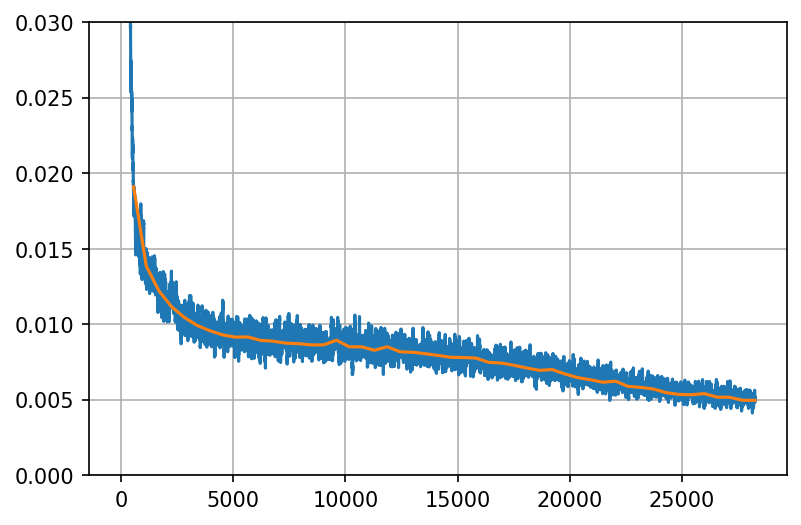

In [16]:
plt.figure(figsize=(6, 4), dpi=150)
plt.grid()
plt.ylim(0, 0.03)

print(len(losses_show) // len(val_losses))

plt.plot(range(len(losses_show)), losses_show)
plt.plot(range(len(losses_show) // len(val_losses), len(losses_show)+1, len(losses_show) // len(val_losses)), val_losses)
plt.show()

In [17]:
model.eval()

with torch.no_grad():

    predictions = []
    # Test
    for i, data in enumerate(test_loader):
        preds = []
        features, targets = data
        i = 0
        consumption = 0
        for f, t in zip(features, targets):
            if i > 0:
                # Set previous consumption to be the last predicted consumption
                f[1] = consumption
                consumption = model(f)
                preds.append(consumption.item())
            elif i == 0:
                consumption = model(f)
                preds.append(consumption.item())
            i+=1
        
        predictions.append([preds, targets])
    



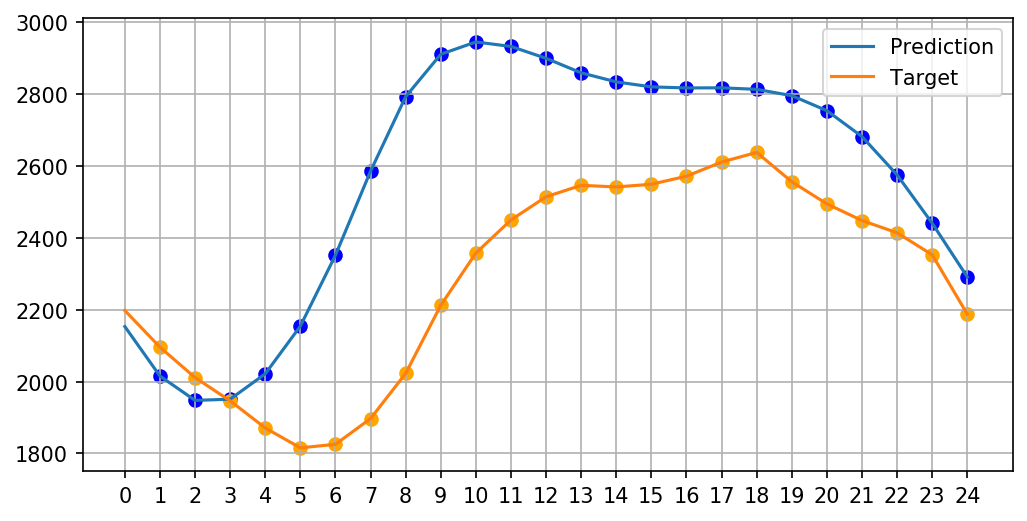

In [18]:
# Plot predictions with true values
prediction_target_plot(predictions, train_mean, train_std, 200)

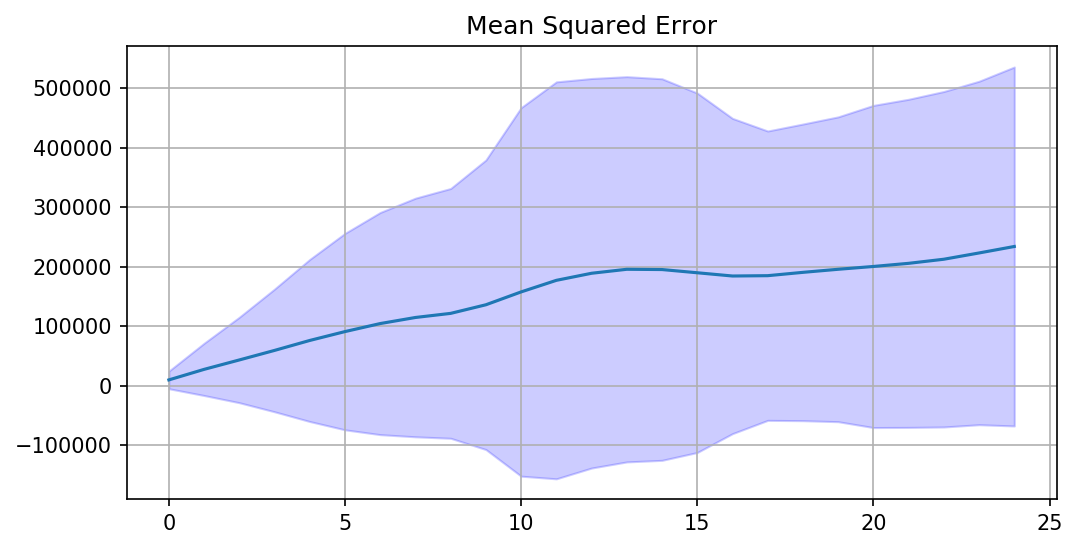

In [19]:
# Plot MSE with standard deviation
mse_plot(predictions, train_mean, train_std)